## Entrenamiento de los modelos 

In [1]:
import json
import pickle
import numpy as np
import logging
import os
import warnings
import joblib
import mlflow
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, precision_recall_fscore_support,
                             precision_score, recall_score, roc_auc_score)
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import  StandardScaler
from sklearn.tree import DecisionTreeClassifier

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
warnings.filterwarnings("ignore")


In [4]:
def read_csv(file_name=str, path="D:/Repositorio/Proyecto-titanic/data_processed")->pd.DataFrame:

    #This function read the csv file
    return pd.read_csv(os.path.join(path, file_name))

def one_hot_encoding(data, columns):
    """
    Esta función aplica one-hot encoding a las columnas especificadas en un DataFrame.
    
    Args:
        data (DataFrame): DataFrame de pandas que contiene los datos.
        columns (list): Lista de nombres de columnas a codificar en one-hot encoding.
    
    Returns:
        DataFrame: DataFrame con las columnas codificadas en one-hot encoding.
    """
    # Convertir las columnas especificadas a tipo string
    data[columns] = data[columns].astype(str)
    
    # Aplicar one-hot encoding
    data_encoded = pd.get_dummies(data, columns=columns, drop_first=True)
    
    # Convertir las columnas codificadas a tipo int
    for column in data_encoded.columns:
        data_encoded[column] = data_encoded[column].astype(int)
    
    return data_encoded

In [5]:
data_titamic = read_csv("titanic.csv")
data_titamic.head(3)

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250


In [6]:
data_titamic_encoded = pd.get_dummies(data_titamic, columns=["Sex"], drop_first=True, dtype=int)
data_titamic_encoded.head(3)

,Survived,Pclass,Name,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Sex_male
0,0,3,Mr. Owen Harris Braund,22.0,1,0,7.2500,1
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,38.0,1,0,71.2833,0
2,1,3,Miss. Laina Heikkinen,26.0,0,0,7.9250,0


In [2]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("Suvirved_titanic")


INFO:alembic.runtime.migration:Context impl SQLiteImpl.
INFO:alembic.runtime.migration:Will assume non-transactional DDL.


<Experiment: artifact_location='file:///d:/Repositorio/Proyecto-titanic/mlruns/1', creation_time=1714756562262, experiment_id='1', last_update_time=1714756562262, lifecycle_stage='active', name='Suvirved_titanic', tags={}>

In [3]:
mlflow.set_experiment("Suvirved_titanic_Entr_2")

2024/05/07 10:19:21 INFO mlflow.tracking.fluent: Experiment with name 'Suvirved_titanic_Entr_2' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///d:/Repositorio/Proyecto-titanic/mlruns/2', creation_time=1715091561212, experiment_id='2', last_update_time=1715091561212, lifecycle_stage='active', name='Suvirved_titanic_Entr_2', tags={}>

In [7]:


def data_transform(df: pd.DataFrame):
    #Thhis function transform the data into X and y
    X = df.drop(["Survived","Name"], axis=1)
    y = df.Survived
    return X, y


def save_pickle(data, filename) -> None:
    """
    This function saves the data in a pickle file
    Args:
        data (object): data to save
        filename (str): filename
    Returns:
        None
    """
    filepath = os.path.join("D:/Repositorio/Proyecto-titanic", "data_processed", f"{filename}.pkl")
    with open(filepath, 'wb') as file:
        pickle.dump(data, file)
        
def split_train_test(
    X: np.array, y: pd.Series, test_size: float = 0.3, random_state: int = 42
) -> tuple:
    """
    This function splits the data into train and test
    Args:
      X_tfidf (np.array): array with the vectorized data
      y (pd.Series): series with the labels
      test_size (float): test size
      random_state (int): random state
    Returns:
      X_train (np.array): array with the vectorized data for train
      X_test (np.array): array with the vectorized data for test
      y_train (pd.Series): series with the labels for train
      y_test (pd.Series): series with the labels for test
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    save_pickle((X_train, y_train), "train")
    save_pickle((X_test, y_test),  "test")
    logger.info("data saved successfully in pickle files")
    return X_train, X_test, y_train.values, y_test.values

def display_classification_report(
    model: object,
    name_model: str,
    developer: str,
    X_train: np.array,
    X_test: np.array,
    y_train: np.array,
    y_test: np.array,
    use_cv = False
):
    """This function display the classification report
    Args:
      model (object): model
      name_model (str): name of the model
      developer (str): developer name
      X_train (np.array): array with the vectorized data for train
      X_test (np.array): array with the vectorized data for test
      y_train (pd.Series): series with the labels for train
      y_test (pd.Series): series with the labels for test
     Returns:
      metric (list): list with the metrics"""
    
    # star experiment in mlflow
    with mlflow.start_run(run_name=name_model):
        mlflow.log_param("model", name_model)
        mlflow.log_param("developer", developer)
        # empty list to store the metrics and then tracking them in mlflow
        metric = []
        y_train_pred_proba = model.predict_proba(X_train)
        y_test_pred_proba = model.predict_proba(X_test)
        roc_auc_score_train = round(
            roc_auc_score(
                y_train, y_train_pred_proba[:,1], average="weighted", multi_class="ovr"
            ),
            2,
        )
        roc_auc_score_test = round(
            roc_auc_score(
                y_test, y_test_pred_proba[:,1], average="weighted", multi_class="ovr"
            ),
            2,
        )

        logger.info("ROC AUC Score Train: %.2f", roc_auc_score_train)
        logger.info("ROC AUC Score Test: %.2f", roc_auc_score_test)

        
        # adding the metrics to the list
        metric.extend([roc_auc_score_train, roc_auc_score_test])

        mlflow.log_metric("roc_auc_train", roc_auc_score_train)
        mlflow.log_metric("roc_auc_test", roc_auc_score_test)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        (
            precision_train,
            recall_train,
            fscore_train,
            support_train,
        ) = precision_recall_fscore_support(y_train, y_train_pred, average="weighted")
        (
            precision_test,
            recall_test,
            fscore_test,
            support_test,
        ) = precision_recall_fscore_support(y_test, y_test_pred, average="weighted")

        mlflow.log_metric("precision_train", precision_train)
        mlflow.log_metric("precision_test", precision_test)
        mlflow.log_metric("recall_train", recall_train)
        mlflow.log_metric("recall_test", recall_test)
        
        try:
            if use_cv:
                best_params = model.best_params_
            else:
                best_params = model.get_params()
            mlflow.log_params(best_params)

        except AttributeError as e:
            logger.info(f"Error: {e}")

        mlflow.sklearn.log_model(model, f"model_{name_model}")

        acc_score_train = round(accuracy_score(y_train, y_train_pred), 2)
        acc_score_test = round(accuracy_score(y_test, y_test_pred), 2)

        metric.extend(
            [
                acc_score_train,
                acc_score_test,
                round(precision_train, 2),
                round(precision_test, 2),
                round(recall_train, 2),
                round(recall_test, 2),
                round(fscore_train, 2),
                round(fscore_test, 2),
            ]
        )

        print("Train Accuracy: ", acc_score_train)
        print("Test Accuracy: ", acc_score_test)

        model_report_train = classification_report(y_train, y_train_pred)
        model_report_test = classification_report(y_test, y_test_pred)

        print("Classification Report for Train:\n", model_report_train)
        print("Classification Report for Test:\n", model_report_test)

        # Plot the confusion matrix
        fig, ax = plt.subplots(figsize=(8, 4))


        cm = confusion_matrix(y_test, y_test_pred)
        cmp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
        cmp.plot(ax=ax)

        plt.xticks(rotation=80)
        plt.show()

        mlflow.sklearn.log_model(model, f"models/{name_model}")

        return metric
    
    
def grid_search(model, folds, params, scoring):
    """This function perform a grid search
    Args:
        model (object): model
        folds (int): number of folds
        params (dict): dictionary with the parameters
        scoring (str): scoring
    Returns:
        grid_search (object): grid search
    """

    grid_search = GridSearchCV(
        model, cv=folds, param_grid=params, scoring=scoring, n_jobs=-1, verbose=1
    )
    return grid_search

def print_best_score_params(model):
    """This functions print best score and best hyperparameters for baselines models
    Args:
        model (object): model
    Returns:
        None"""
    print("Best Score: ", model.best_score_)
    print("Best Hyperparameters: ", model.best_params_)



In [8]:

X, y = data_transform(data_titamic_encoded)
X_train, X_test, y_train, y_test = split_train_test(X, y)

print(data_titamic.shape)
print(X.shape)
print(y.shape)
print(X_train.shape)
print(y_train.shape)

INFO:__main__:data saved successfully in pickle files


(887, 8)
(887, 6)
(887,)
(620, 6)
(620,)


#### Modelo de Regresion logistica

INFO:__main__:ROC AUC Score Train: 0.87
INFO:__main__:ROC AUC Score Test: 0.82


Train Accuracy:  0.82
Test Accuracy:  0.77
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.84      0.88      0.86       379
           1       0.79      0.73      0.76       241

    accuracy                           0.82       620
   macro avg       0.81      0.80      0.81       620
weighted avg       0.82      0.82      0.82       620

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.77      0.89      0.83       166
           1       0.76      0.57      0.66       101

    accuracy                           0.77       267
   macro avg       0.77      0.73      0.74       267
weighted avg       0.77      0.77      0.76       267



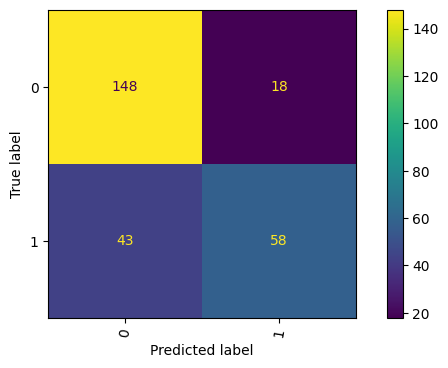

[0.87, 0.82, 0.82, 0.77, 0.82, 0.77, 0.82, 0.77, 0.82, 0.76]

In [10]:
log_reg = LogisticRegression(random_state=40)
log_reg.fit(X_train,y_train)
display_classification_report(model=log_reg, 
                              name_model="LogisticRegression", 
                              developer="Jose Luis", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test, 
                              use_cv=False)

#### Modelo Multinomial Naive Bayes

INFO:__main__:ROC AUC Score Train: 0.73
INFO:__main__:ROC AUC Score Test: 0.74


Train Accuracy:  0.68
Test Accuracy:  0.69
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.71      0.83      0.76       379
           1       0.63      0.46      0.53       241

    accuracy                           0.68       620
   macro avg       0.67      0.64      0.65       620
weighted avg       0.68      0.68      0.67       620

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.72      0.84      0.77       166
           1       0.63      0.46      0.53       101

    accuracy                           0.69       267
   macro avg       0.67      0.65      0.65       267
weighted avg       0.68      0.69      0.68       267



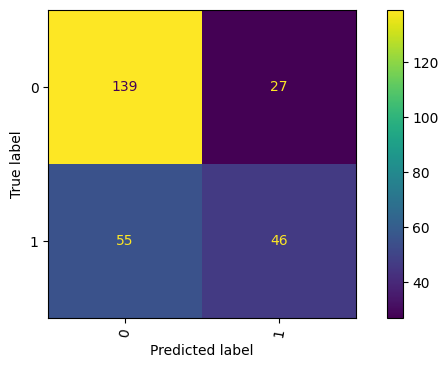

[0.73, 0.74, 0.68, 0.69, 0.68, 0.68, 0.68, 0.69, 0.67, 0.68]

In [11]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
display_classification_report(model=mnb, 
                              name_model="MultinomialNB", 
                              developer="Jose Luis", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test)

#### Decision tree Clasifier

INFO:__main__:ROC AUC Score Train: 1.00
INFO:__main__:ROC AUC Score Test: 0.75


Train Accuracy:  0.99
Test Accuracy:  0.77
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       379
           1       1.00      0.96      0.98       241

    accuracy                           0.99       620
   macro avg       0.99      0.98      0.98       620
weighted avg       0.99      0.99      0.99       620

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.82      0.81      0.82       166
           1       0.70      0.70      0.70       101

    accuracy                           0.77       267
   macro avg       0.76      0.76      0.76       267
weighted avg       0.77      0.77      0.77       267



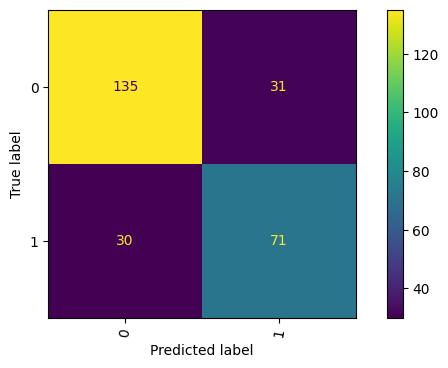

[1.0, 0.75, 0.99, 0.77, 0.99, 0.77, 0.99, 0.77, 0.99, 0.77]

In [12]:
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)
display_classification_report(model=dtc, 
                              name_model="DecisionTreeClassifier", 
                              developer="Jose Luis", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test)

#### Suport Vector Machine

INFO:__main__:ROC AUC Score Train: 0.95
INFO:__main__:ROC AUC Score Test: 0.75


Train Accuracy:  0.92
Test Accuracy:  0.68
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.91      0.96      0.93       379
           1       0.94      0.84      0.89       241

    accuracy                           0.92       620
   macro avg       0.92      0.90      0.91       620
weighted avg       0.92      0.92      0.92       620

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.71      0.82      0.76       166
           1       0.60      0.45      0.51       101

    accuracy                           0.68       267
   macro avg       0.65      0.63      0.64       267
weighted avg       0.67      0.68      0.67       267



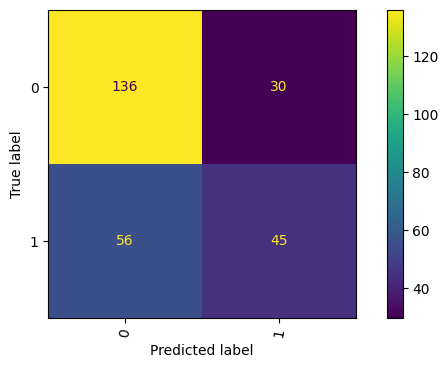

[0.95, 0.75, 0.92, 0.68, 0.92, 0.67, 0.92, 0.68, 0.92, 0.67]

In [20]:
svc = SVC(gamma="auto", probability=True, random_state=42)
svc.fit(X_train, y_train)
display_classification_report(model=svc, 
                              name_model="SVC", 
                              developer="Jose Luis", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test)

#### Ramdon Forest

INFO:__main__:ROC AUC Score Train: 0.87
INFO:__main__:ROC AUC Score Test: 0.84


Train Accuracy:  0.82
Test Accuracy:  0.74
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.78      0.99      0.87       379
           1       0.97      0.56      0.71       241

    accuracy                           0.82       620
   macro avg       0.88      0.78      0.79       620
weighted avg       0.86      0.82      0.81       620

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.72      0.96      0.82       166
           1       0.86      0.38      0.52       101

    accuracy                           0.74       267
   macro avg       0.79      0.67      0.67       267
weighted avg       0.77      0.74      0.71       267



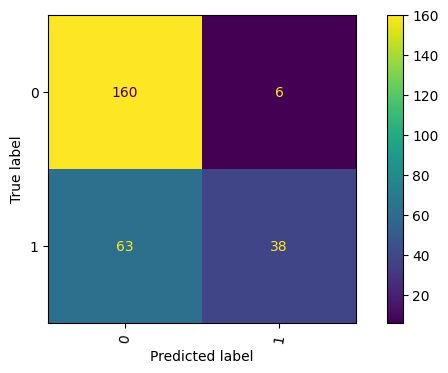

[0.87, 0.84, 0.82, 0.74, 0.86, 0.77, 0.82, 0.74, 0.81, 0.71]

In [14]:
rf = RandomForestClassifier(max_depth=2,random_state=42)
rf.fit(X_train, y_train)
display_classification_report(model= rf,
                              name_model="RandomForestClassifier", 
                              developer="Jose Luis", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test)


#### Redes neuronales artificiales

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', random_state=42)
mlp.fit(X_train, y_train)
display_classification_report(model=mlp, 
                              name_model="MLPClassifier", 
                              developer="Jose Luis", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test)

#### Modelo de regresion logistica con GridSearchCV

In [9]:
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 40)

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
Best Score:  0.8161290322580645
Best Hyperparameters:  {'C': 10, 'class_weight': None, 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.001, 'warm_start': True}


INFO:__main__:ROC AUC Score Train: 0.87
INFO:__main__:ROC AUC Score Test: 0.82


Train Accuracy:  0.82
Test Accuracy:  0.77
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.84      0.88      0.86       379
           1       0.79      0.73      0.76       241

    accuracy                           0.82       620
   macro avg       0.81      0.80      0.81       620
weighted avg       0.82      0.82      0.82       620

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.77      0.89      0.83       166
           1       0.75      0.57      0.65       101

    accuracy                           0.77       267
   macro avg       0.76      0.73      0.74       267
weighted avg       0.77      0.77      0.76       267



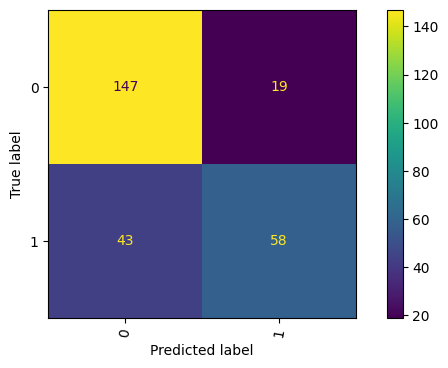

[0.87, 0.82, 0.82, 0.77, 0.82, 0.77, 0.82, 0.77, 0.82, 0.76]

In [10]:
log_reg = LogisticRegression()

params_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 300],
    'class_weight': [None, 'balanced'],
    'tol': [1e-3, 1e-4, 1e-5],
    'fit_intercept': [True, False],
    'warm_start': [True, False]
}


grid_search_log = grid_search(log_reg, folds, params_grid, scoring="accuracy")
grid_search_log.fit(X_train, y_train)  # entrenamiento con los datos rebalanceados

print_best_score_params(grid_search_log)
display_classification_report(grid_search_log,
                              name_model="LogisticRegressionCVSmote", 
                              developer="Jose Luis", 
                              X_train=X_train,  # evaluación con los datos rebalanceados
                              X_test=X_test, 
                              y_train=y_train,  # etiquetas rebalanceadas
                              y_test=y_test, 
                              use_cv=True)

#### Modelo Multinomial bayes con gridSearchCv

Fitting 5 folds for each of 32 candidates, totalling 160 fits


INFO:__main__:ROC AUC Score Train: 0.73
INFO:__main__:ROC AUC Score Test: 0.74


Best Score:  0.6887096774193548
Best Hyperparameters:  {'alpha': 0.1, 'class_prior': [0.2, 0.8], 'fit_prior': True}
Train Accuracy:  0.69
Test Accuracy:  0.7
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.72      0.81      0.76       379
           1       0.63      0.49      0.55       241

    accuracy                           0.69       620
   macro avg       0.67      0.65      0.66       620
weighted avg       0.68      0.69      0.68       620

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.74      0.82      0.77       166
           1       0.63      0.51      0.57       101

    accuracy                           0.70       267
   macro avg       0.68      0.67      0.67       267
weighted avg       0.70      0.70      0.70       267



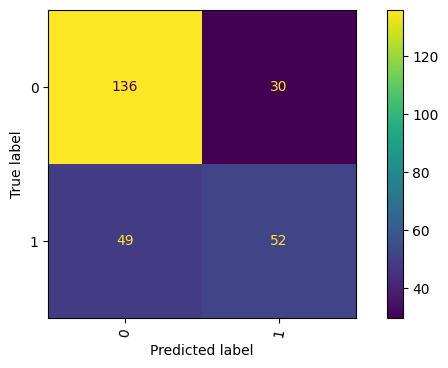

[0.73, 0.74, 0.69, 0.7, 0.68, 0.7, 0.69, 0.7, 0.68, 0.7]

In [11]:
mnb = MultinomialNB()
params_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0],  # Parámetro de suavizado de Laplace
    'fit_prior': [True, False],  # Si se debe aprender o no las probabilidades a priori de clase
    'class_prior': [None, [0.1, 0.9], [0.2, 0.8], [0.3, 0.7]]  # Probabilidades a priori de clase
}
grid_search_mnb = grid_search(mnb, folds, params_grid, scoring="accuracy")
grid_search_mnb.fit(X_train, y_train)
print_best_score_params(grid_search_mnb)

display_classification_report(model= grid_search_mnb,
                              name_model="MultinomialNBCV",
                              developer= "Jose Luis",
                              X_train= X_train,
                              X_test= X_test,
                              y_train= y_train,
                              y_test= y_test,
                              use_cv= True)

#### Modelo Decision Tree Clasifier con GridSearchCV

Fitting 5 folds for each of 93312 candidates, totalling 466560 fits


INFO:__main__:ROC AUC Score Train: 0.92
INFO:__main__:ROC AUC Score Test: 0.85


Best Score:  0.8419354838709678
Best Hyperparameters:  {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
Train Accuracy:  0.86
Test Accuracy:  0.81
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88       379
           1       0.82      0.82      0.82       241

    accuracy                           0.86       620
   macro avg       0.85      0.85      0.85       620
weighted avg       0.86      0.86      0.86       620

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85       166
           1       0.77      0.71      0.74       101

    accuracy                           0.81       267
   macro avg       0.80   

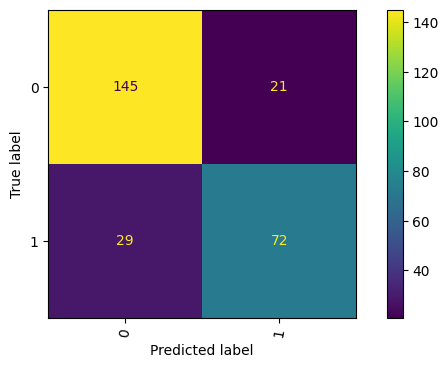

[0.92, 0.85, 0.86, 0.81, 0.86, 0.81, 0.86, 0.81, 0.86, 0.81]

In [13]:
dtc = DecisionTreeClassifier()
params_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],  # Criterio para medir la calidad de una división
    'splitter': ['best', 'random'],  # Estrategia utilizada para elegir la división en cada nodo
    'max_depth': [None, 5, 10, 20],  # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],  # Número mínimo de muestras requeridas para dividir un nodo interno
    'min_samples_leaf': [1, 2, 4],  # Número mínimo de muestras requeridas para estar en un nodo hoja
    'min_weight_fraction_leaf': [0.0, 0.1, 0.2],  # Fracción mínima del peso total de las muestras requerida para estar en un nodo hoja
    'max_features': [None, 'sqrt', 'log2'],  # Número de características a considerar al buscar la mejor división
    'random_state': [None, 42],  # Controla la aleatoriedad del estimador
    'max_leaf_nodes': [None, 5, 10, 20],  # Crecimiento del árbol con un número máximo de nodos hoja
    'min_impurity_decrease': [0.0, 0.1, 0.2],  # Un nodo se dividirá si esta división induce una disminución de la impureza mayor o igual a este valor
    'class_weight': [None, 'balanced'] # Pesos asociados con las clases
}
grid_search_dtc = grid_search(dtc,folds, params_grid, scoring=("accuracy"))
grid_search_dtc.fit(X_train, y_train)
print_best_score_params(grid_search_dtc)
display_classification_report(model= grid_search_dtc,
                              name_model="DecisionTreeClassifierCV",
                              developer= "Jose Luis",
                              X_train= X_train,
                              X_test= X_test,
                              y_train= y_train,
                              y_test= y_test,
                              use_cv= True)

#### Modelo Suport Vector Machine con GridSearchCV

Fitting 5 folds for each of 5184 candidates, totalling 25920 fits


INFO:__main__:ROC AUC Score Train: 0.91
INFO:__main__:ROC AUC Score Test: 0.82


Best Score:  0.785483870967742
Best Hyperparameters:  {'C': 10.0, 'class_weight': 'balanced', 'decision_function_shape': 'ovo', 'gamma': 0.01, 'kernel': 'rbf', 'max_iter': 300, 'shrinking': True, 'tol': 0.001}
Train Accuracy:  0.87
Test Accuracy:  0.77
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.92      0.86      0.89       379
           1       0.80      0.88      0.84       241

    accuracy                           0.87       620
   macro avg       0.86      0.87      0.86       620
weighted avg       0.87      0.87      0.87       620

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.85      0.77      0.81       166
           1       0.67      0.77      0.72       101

    accuracy                           0.77       267
   macro avg       0.76      0.77      0.76       267
weighted avg       0.78      0.77      0.77       267



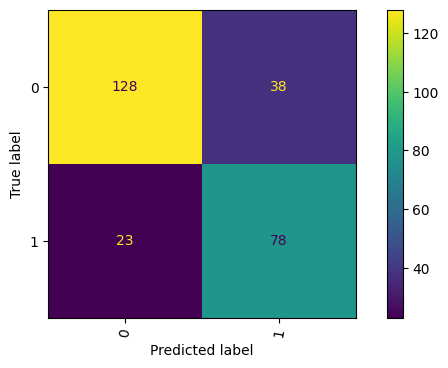

[0.91, 0.82, 0.87, 0.77, 0.87, 0.78, 0.87, 0.77, 0.87, 0.77]

In [18]:
svc = SVC(probability=True)

params_grid = {
    'C': [0.1, 1.0, 10.0],  # Parámetro de regularización
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Tipo de kernel
    'gamma': ['scale', 'auto', 0.1, 0.01],  # Coeficiente del kernel
    'shrinking': [True, False],  # Si usar la heurística de reducción
    'tol': [1e-3, 1e-4, 1e-5],  # Tolerancia para el criterio de detención
    'class_weight': [None, 'balanced', {0: 1, 1: 5}],  # Pesos asociados con las clases
    'max_iter': [100, 200, 300],  # Límite de iteraciones dentro del solucionador
    'decision_function_shape': ['ovo', 'ovr'],  # Formato de la función de decisión
}
grid_search_svc = grid_search(svc, folds, params_grid, scoring= "accuracy")
grid_search_svc.fit(X_train, y_train)
print_best_score_params(grid_search_svc)

display_classification_report(model=grid_search_svc,
                              name_model="SuportVectorMachineCV",
                              developer="Jose Luis",
                              X_train= X_train,
                              X_test= X_test,
                              y_train= y_train,
                              y_test= y_test,
                              use_cv= True)

#### Modelo Random Forest con GridSearchCV

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


INFO:__main__:ROC AUC Score Train: 0.98
INFO:__main__:ROC AUC Score Test: 0.84


Best Score:  0.8661290322580646
Best Hyperparameters:  {'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'n_jobs': -1}
Train Accuracy:  0.93
Test Accuracy:  0.82
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94       379
           1       0.96      0.85      0.90       241

    accuracy                           0.93       620
   macro avg       0.94      0.92      0.92       620
weighted avg       0.93      0.93      0.93       620

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.82      0.92      0.86       166
           1       0.83      0.66      0.74       101

    accuracy                           0.82       267
   macro avg       0.82      0.79      0.80       267
weighted avg       0.82      0.82      0.82       267



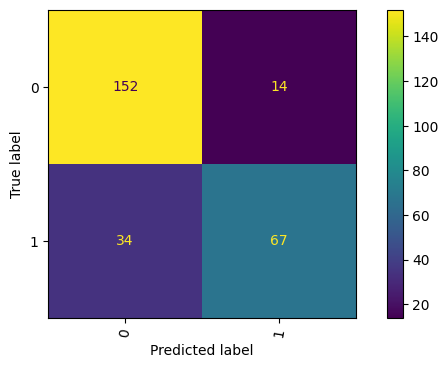

[0.98, 0.84, 0.93, 0.82, 0.93, 0.82, 0.93, 0.82, 0.93, 0.82]

In [15]:
rf = RandomForestClassifier()
params_grid = {
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'n_jobs': [-1],
    'class_weight': [None, 'balanced']
}
grid_search_rf = grid_search(rf, folds, params_grid, scoring= "accuracy")
grid_search_rf.fit(X_train, y_train)
print_best_score_params(grid_search_rf)
display_classification_report(model=grid_search_rf,
                              name_model="RandomForestClassifierCV",
                              developer="Jose Luis",
                              X_train= X_train,
                              X_test= X_test,
                              y_train= y_train,
                              y_test= y_test,
                              use_cv= True)

#### Modelo de Redes neuronales artificiales con GridSearchCV

Fitting 5 folds for each of 64 candidates, totalling 320 fits


INFO:__main__:ROC AUC Score Train: 0.88
INFO:__main__:ROC AUC Score Test: 0.83


Best Score:  0.8241935483870968
Best Hyperparameters:  {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'early_stopping': False, 'hidden_layer_sizes': (100, 50), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}
Train Accuracy:  0.79
Test Accuracy:  0.76
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.77      0.94      0.85       379
           1       0.86      0.56      0.68       241

    accuracy                           0.79       620
   macro avg       0.82      0.75      0.76       620
weighted avg       0.81      0.79      0.78       620

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.74      0.95      0.83       166
           1       0.85      0.45      0.58       101

    accuracy                           0.76       267
   macro avg       0.79      0.70      0.71       267
weighted avg       0.78      0.76      0.74       26

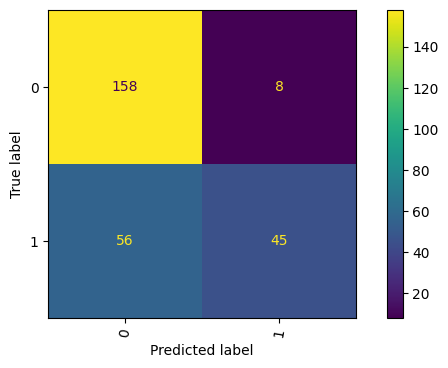

[0.88, 0.83, 0.79, 0.76, 0.81, 0.78, 0.79, 0.76, 0.78, 0.74]

In [19]:
mlp = MLPClassifier()
params_grid = {
    'hidden_layer_sizes': [(100,), (50,), (100, 50), (50, 50)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001],
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [200],
    'batch_size': ['auto', 50],
    'early_stopping': [True, False]
}

grid_search_mlp = grid_search(mlp, folds, params_grid, scoring= "accuracy")
grid_search_mlp.fit(X_train, y_train)
print_best_score_params(grid_search_mlp)
display_classification_report(model=grid_search_mlp,
                              name_model="MLPClassifierCV",
                              developer="Jose Luis",
                              X_train= X_train,
                              X_test= X_test,
                              y_train= y_train,
                              y_test= y_test,
                              use_cv= True)